CSCE 636 Deep Learing  
Name: Tian Liu  
UIN: 525004380


1) Check out the Jupyter notebook for Chapter 7 at https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter07_working-with-keras.ipynb . Answer the questions: (1) What is the advantage of using  Sequential Models? (2) What is the advantage of using Functional API? (3) What is the advantage of using Subclassing? (5 points)

Answer:  

(1) Advantages of using sequential models: the sequential model is the easist way to build the deep learning model, and also friendly to novice users. But it is not that flexible in design model architectures and only limited to simple stack of layers.

(2) For Functional API, it represents a nice mid-point between the usability and flexibility. Users can use Funtional API to build more complex models such as multiple input and multiple output models.

(3) The Subclassing is the most flexible methos to build a model. User have full control on everything and can build the model in whichever way they want. However, the user won't get access to many built-in Keras features and will be more at risk of making mistakes.

2) For the MNIST Dataset (for handwritten digit recognition), in the past, we built a one-input-one-output model, where the input is an image, and the output is a length-10 vector that represents a probability vector for the 10 classes (from class 0 to class 9). Today, let's build a one-input-multiple-output model, which has 10 outputs y_0, y_1, y_2, ..., y_9, where each y_i (for i between 0 and 9) is a real number between 0 and 1 that represents the probability for the input image to belong to class i. (That is, the probability that the input image does not belong to class i is 1 - y_i.) In other words, this new model is a combination of 10 binary classifiers (that is, one binary classifier for each class). The loss function for each y_i is the binary cross-entropy function, and the overall loss for the model is the summation of the 10 binary cross-entropies.

Let's define a new performance metric "aggregateAccuracy" as follows. First, we pick y_i* to be the maximum value among y_0, y_1, y_2, ..., y_9. Then, we let i* be the label that our model predicts for the input image. Then, "aggregateAccuracy" is simply the "accuracy" that we usually talk about: it is the fraction of images whose predicted label equals the true label.

Now compile your model and train it (with the loss function and performance metric defined above), and test the trained model's performance on the testing data. 

What you need to submit: (1) the complete code; (2) the training performance for training data and validation data (for both loss and aggregationAccuracy) shown in figures, where the x-axis is the number of epochs, and the y-axis is the loss or aggregateAccuracy; (3) show the test performance (loss and aggregateAccuracy) as two numbers. (15 points)

Added Comment: the above peformance metric "aggregateAccuracy" is for the whole model, not for each of the 10 binary classifiers. However, if you find it hard to do (for example, what we learned in class requires each model output to have its own list of performance metrics), you can try to get around this technical issue. For example, you might consider defining a second model that takes the first model's 10 outputs as input, aggregate them into one output, then define the "aggregateAccuracy" for the second model. This might make it a little bit more complex to plot the performance figure; but remember: with coding, anything is possible. 

Answer:  

The code below implements Functional API and Subclassing to build the one-input-multiple-output model.

In [26]:
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from numpy import random
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

In [35]:
# define controls for the code
num_class = 10
model_construct = "FAPI" # FAPI = functional API, SCLA = subclassing
#model_construct = "SCLA"

##### Prepare the MNIST data and labels

In [36]:
# prepare the data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

# split the train dataset further into train and val
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, shuffle=True)

# process the labels 
def get_binary_labels(labels):

  res = np.zeros((num_class, len(labels)), dtype=int)
  
  for idx, lb in enumerate(labels):
    res[lb-1, idx] = 1

  res_dict = dict()
  if model_construct == "FAPI":
    for i in range(num_class):
      res_dict["BinaryClassifier_{}".format(i)] = res[i] # here the keys used are the output layer names in model architecture defined below
      
  elif model_construct == "SCLA":
    for i in range(num_class):
      res_dict["output_{}".format(i+1)] = res[i] # use default output name starting from "output_1"
  
  else:
      print("Unrecognized mode_construct {}".format(model_construct))
      raise ValueError

  return res_dict

def check_dict(dictionary):
  total = 0
  for k, v in dictionary.items():
    ct = sum(v==1)
    print(k, ct)
    total += ct
  print('total =', total)

y_train_dict = get_binary_labels(y_train)
print("train binary labels:")
check_dict(y_train_dict)

y_val_dict = get_binary_labels(y_val)
print("\nval binary labels:")
check_dict(y_val_dict)

test_bin_labels_dict = get_binary_labels(test_labels)
print("\ntest binary labels:")
check_dict(test_bin_labels_dict)

train binary labels:
BinaryClassifier_0 5363
BinaryClassifier_1 4758
BinaryClassifier_2 4933
BinaryClassifier_3 4657
BinaryClassifier_4 4332
BinaryClassifier_5 4779
BinaryClassifier_6 4984
BinaryClassifier_7 4684
BinaryClassifier_8 4797
BinaryClassifier_9 4713
total = 48000

val binary labels:
BinaryClassifier_0 1379
BinaryClassifier_1 1200
BinaryClassifier_2 1198
BinaryClassifier_3 1185
BinaryClassifier_4 1089
BinaryClassifier_5 1139
BinaryClassifier_6 1281
BinaryClassifier_7 1167
BinaryClassifier_8 1152
BinaryClassifier_9 1210
total = 12000

test binary labels:
BinaryClassifier_0 1135
BinaryClassifier_1 1032
BinaryClassifier_2 1010
BinaryClassifier_3 982
BinaryClassifier_4 892
BinaryClassifier_5 958
BinaryClassifier_6 1028
BinaryClassifier_7 974
BinaryClassifier_8 1009
BinaryClassifier_9 980
total = 10000


##### Build the One Input Multiple Output model using Function API or Subclassing

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 MNIST_images (InputLayer)      [(None, 784)]        0           []                               
                                                                                                  
 Features (Dense)               (None, 256)          200960      ['MNIST_images[0][0]']           
                                                                                                  
 BinaryClassifier_0 (Dense)     (None, 1)            257         ['Features[0][0]']               
                                                                                                  
 BinaryClassifier_1 (Dense)     (None, 1)            257         ['Features[0][0]']               
                                                                                            

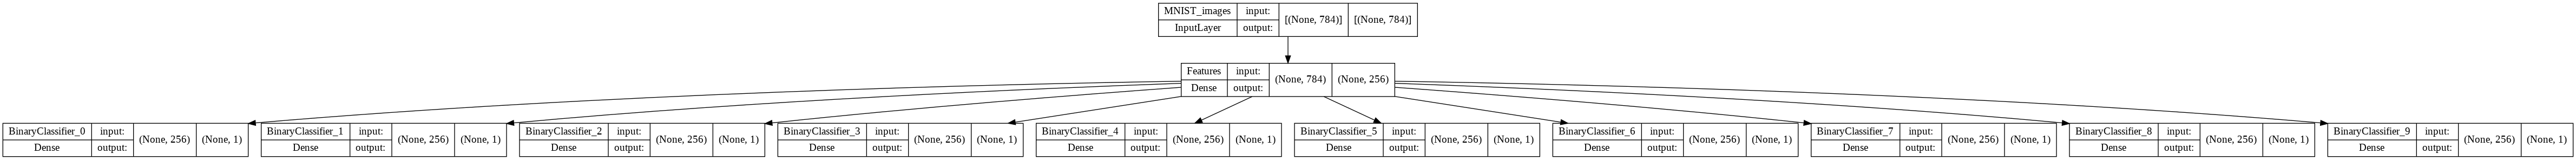

In [37]:
if model_construct == "FAPI":

  # use Functional API
  inputs = keras.Input(shape=(train_images.shape[1],), name="MNIST_images")
  features = layers.Dense(256, activation="relu", name="Features")(inputs)

  output_lst = []
  for i in range(10):
    output = layers.Dense(1, activation="sigmoid", name="BinaryClassifier_{}".format(i))(features)
    output_lst.append(output)

  model = keras.Model(inputs=inputs, outputs=output_lst)

  model.summary()
  # keras.utils.plot_model(model, 'Functional_API_Model.png', show_shapes=True)

elif model_construct == "SCLA":

  # use Subclass to build the multiple output model
  # inputs = keras.Input(shape=(784,))
  class MyModel(keras.Model):

      def __init__(self, num_output):
          super().__init__()
          self.num_output = num_output
          self.mixing_layer = layers.Dense(256, activation="relu")
          # self.digit_classifier = layers.Dense(1, activation="sigmoid") # cannot reuse, even though the layer is the same
          
          self.digit_classifier_lst = []
          for i in range(num_output):
            # digit_classifier = layers.Dense(1, activation="sigmoid", name="BinaryClassifier_{}".format(i))
            digit_classifier = layers.Dense(1, activation="sigmoid")
            self.digit_classifier_lst.append(digit_classifier)

      def call(self, inputs):

          features = self.mixing_layer(inputs)

          outputs = []
          for i in range(self.num_output):
            prob = self.digit_classifier_lst[i](features)
            outputs.append(prob)

          return outputs
      
  num_class = 10
  model = MyModel(num_output=num_class)

  outputs = model(train_images)

  model.summary()
  keras.utils.plot_model(model, 'Subclass_Model.png') # not working for subclass

else:
  print("Unrecognized mode_construct {}".format(model_construct))
  raise ValueError

keras.utils.plot_model(model, 'Model.png', show_shapes=True)

##### Compile and train the model, use default Callback functions to get aggregrate accuracy

In [38]:
import tensorflow as tf

train_agg_acc = []
val_agg_acc = []

def get_class_label(model_output):
  # model_output is a list of list (10 x 48000)

  class_num = len(model_output)
  data_num = len(model_output[0])

  res = []
  for d in range(data_num):
    output = [model_output[i][d] for i in range(class_num)]
    label = output.index(max(output)) + 1 # notice the +1 here because labels starts from 1
    res.append(label)
  
  return res

# define customized metric as callback function
class aggregateAccuracy(keras.callbacks.Callback):

    def on_epoch_begin(self, epoch, logs):
        self.train_agg_acc = 0 
        self.val_agg_acc = 0 
    
    def on_epoch_end(self, epoch, logs):

        y_train_output = model.predict(X_train)
        y_train_pred = get_class_label(y_train_output)
        self.train_agg_acc = sum(y_train_pred == y_train) / len(y_train_pred)

        # print()
        # print(type(y_train_output))
        # print(len(y_train_output))
        # print(len(y_train_output[0]))
        # print((y_train_output))
        
        y_val_output = model.predict(X_val)
        y_val_pred = get_class_label(y_val_output)
        self.val_agg_acc = sum(y_val_pred == y_val) / len(y_val_pred)
        
        logs['train_agg_auc'] = self.train_agg_acc
        logs['val_agg_auc'] = self.val_agg_acc

        train_agg_acc.append(self.train_agg_acc)
        val_agg_acc.append(self.val_agg_acc)
      
        print("Epoch {}, train_loss = {:.4f}, val_loss = {:.4f}, train_agg_auc = {:.4f}, val_agg_auc = {:.4f}".format(epoch+1, \
              logs['loss'], logs['val_loss'], self.train_agg_acc, self.val_agg_acc))


model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              # metrics = "accuracy"
              # metrics=[output_prob]
              )

agg_auc = aggregateAccuracy()
history = model.fit(
          # {'MNIST_images': X_train},
          X_train,
          y_train_dict,
          validation_data=(X_val, y_val_dict),
          callbacks=[agg_auc],
          # batch_size=50,
          verbose=0,
          shuffle=True,
          epochs=10)

Epoch 1, train_loss = 0.5272, val_loss = 0.3087, train_agg_auc = 0.8646, val_agg_auc = 0.8524
Epoch 2, train_loss = 0.2379, val_loss = 0.2385, train_agg_auc = 0.8792, val_agg_auc = 0.8682
Epoch 3, train_loss = 0.1784, val_loss = 0.2111, train_agg_auc = 0.8865, val_agg_auc = 0.8726
Epoch 4, train_loss = 0.1453, val_loss = 0.2011, train_agg_auc = 0.8891, val_agg_auc = 0.8743
Epoch 5, train_loss = 0.1241, val_loss = 0.2060, train_agg_auc = 0.8909, val_agg_auc = 0.8762
Epoch 6, train_loss = 0.1089, val_loss = 0.1986, train_agg_auc = 0.8930, val_agg_auc = 0.8773
Epoch 7, train_loss = 0.0943, val_loss = 0.2178, train_agg_auc = 0.8938, val_agg_auc = 0.8769
Epoch 8, train_loss = 0.0826, val_loss = 0.2140, train_agg_auc = 0.8959, val_agg_auc = 0.8792
Epoch 9, train_loss = 0.0722, val_loss = 0.2221, train_agg_auc = 0.8968, val_agg_auc = 0.8776
Epoch 10, train_loss = 0.0638, val_loss = 0.2500, train_agg_auc = 0.8970, val_agg_auc = 0.8766


##### Check train and val scores for overfitting

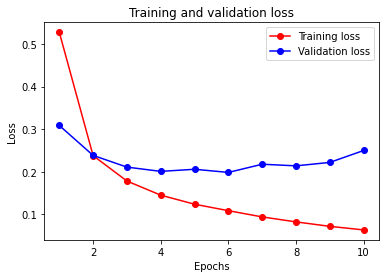

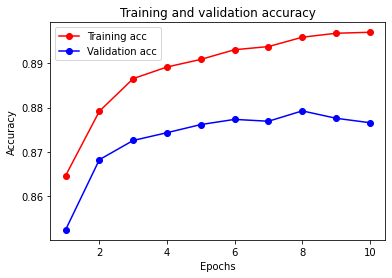

In [39]:
# plot training and validation loss and acc
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "r", marker="o", label="Training loss")
plt.plot(epochs, val_loss_values, "b", marker="o",label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.clf()
# acc = history_dict["train_agg_acc"]
# val_acc = history_dict["val_agg_acc"]
acc = train_agg_acc
val_acc = val_agg_acc        
plt.plot(epochs, acc, "r", marker="o", label="Training acc")
plt.plot(epochs, val_acc, "b", marker="o", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

##### Retrain the model

Notice the val_loss starts to increase after epoch 6, thus overfitting starts after epoch 6. So we retrain the model for 6 epochs, then test on the test data.

In [44]:
if model_construct == "FAPI":

  # use Functional API
  inputs = keras.Input(shape=(train_images.shape[1],), name="MNIST_images")
  features = layers.Dense(256, activation="relu", name="Features")(inputs)

  output_lst = []
  for i in range(10):
    output = layers.Dense(1, activation="sigmoid", name="BinaryClassifier_{}".format(i))(features)
    output_lst.append(output)

  model = keras.Model(inputs=inputs, outputs=output_lst)

  # model.summary()
  # keras.utils.plot_model(model, 'Functional_API_Model.png', show_shapes=True)

elif model_construct == "SCLA":

  # use Subclass to build the multiple output model
  # inputs = keras.Input(shape=(784,))
  class MyModel(keras.Model):

      def __init__(self, num_output):
          super().__init__()
          self.num_output = num_output
          self.mixing_layer = layers.Dense(256, activation="relu")
          # self.digit_classifier = layers.Dense(1, activation="sigmoid") # cannot reuse, even though the layer is the same
          
          self.digit_classifier_lst = []
          for i in range(num_output):
            # digit_classifier = layers.Dense(1, activation="sigmoid", name="BinaryClassifier_{}".format(i))
            digit_classifier = layers.Dense(1, activation="sigmoid")
            self.digit_classifier_lst.append(digit_classifier)

      def call(self, inputs):

          features = self.mixing_layer(inputs)

          outputs = []
          for i in range(self.num_output):
            prob = self.digit_classifier_lst[i](features)
            outputs.append(prob)

          return outputs
      
  num_class = 10
  model = MyModel(num_output=num_class)

  outputs = model(train_images)

  # model.summary()
  # keras.utils.plot_model(model, 'Subclass_Model.png') # not working for subclass

else:
  print("Unrecognized mode_construct {}".format(model_construct))
  raise ValueError

In [45]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              # metrics=[output_prob]
              )

train_agg_acc = []
val_agg_acc = []
agg_auc = aggregateAccuracy()
history = model.fit(
          X_train,
          y_train_dict,
          validation_data=(X_val, y_val_dict),
          callbacks=[agg_auc],
          # batch_size=50,
          verbose=0,
          shuffle=True,
          epochs=6)

Epoch 1, train_loss = 0.5215, val_loss = 0.3096, train_agg_auc = 0.8668, val_agg_auc = 0.8570
Epoch 2, train_loss = 0.2370, val_loss = 0.2575, train_agg_auc = 0.8783, val_agg_auc = 0.8654
Epoch 3, train_loss = 0.1791, val_loss = 0.2149, train_agg_auc = 0.8862, val_agg_auc = 0.8720
Epoch 4, train_loss = 0.1453, val_loss = 0.2137, train_agg_auc = 0.8892, val_agg_auc = 0.8737
Epoch 5, train_loss = 0.1230, val_loss = 0.2097, train_agg_auc = 0.8923, val_agg_auc = 0.8756
Epoch 6, train_loss = 0.1075, val_loss = 0.2349, train_agg_auc = 0.8921, val_agg_auc = 0.8736


##### Check test performance

In [46]:
# test performance
result = model.evaluate(test_images, test_bin_labels_dict)
test_loss = result[0]

y_test_output = model.predict(test_images)
y_test_pred = get_class_label(y_test_output)
test_agg_acc = sum(y_test_pred == test_labels) / len(y_test_pred)

print("test_loss = {:.4f}".format(test_loss))
print("test_agg_acc = {:.4f}".format(test_agg_acc))

313/313 [==============================] - 2s 4ms/step - loss: 0.1854 - BinaryClassifier_0_loss: 0.0093 - BinaryClassifier_1_loss: 0.0226 - BinaryClassifier_2_loss: 0.0190 - BinaryClassifier_3_loss: 0.0154 - BinaryClassifier_4_loss: 0.0187 - BinaryClassifier_5_loss: 0.0179 - BinaryClassifier_6_loss: 0.0222 - BinaryClassifier_7_loss: 0.0189 - BinaryClassifier_8_loss: 0.0259 - BinaryClassifier_9_loss: 0.0155
test_loss = 0.1854
test_agg_acc = 0.8827
